In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import datetime
import requests
from tqdm import tqdm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.tsatools import add_trend
import statsmodels.api as sm
import holidays

from watermark import watermark

print(watermark())

Last updated: 2024-11-30T12:07:58.774736+03:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.28.0

Compiler    : GCC 14.2.1 20240921
OS          : Linux
Release     : 6.12.1-gentoo
Machine     : x86_64
Processor   : AMD Ryzen 9 5950X 16-Core Processor
CPU cores   : 32
Architecture: 64bit



## Загрузка данных

In [2]:
time_history_url = "https://deepstatemap.live/api/history/public"

In [3]:
# Making a get request
response = requests.get(time_history_url)

df = pd.DataFrame()
# print json content
t = len(response.json())
Path("data/").mkdir(exist_ok=True)
with tqdm(total=t) as pbar:
    for n, i in enumerate(response.json()):
        timestamp = i["id"]
        time_index = datetime.datetime.fromtimestamp(timestamp)
        pbar.set_description(str(time_index.date()), refresh=True)
        area = requests.get(f"https://deepstatemap.live/api/history/{timestamp}/areas")
        js_df = pd.json_normalize(area.json()).assign(time_index=time_index)
        df = pd.concat([df, js_df], ignore_index=True)
        pbar.update(1)
df

2024-11-30: 100%|██████████| 1113/1113 [13:25<00:00,  1.38it/s]


,hash,area,percent,type,time_index
0,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 15:33:28
1,#880e4f,46937.208199,7.775,occupied_to_24_02_2022,2022-04-03 15:33:28
2,#bcaaa4,5587.522472,0.926,unspecified,2022-04-03 15:33:28
3,#0f9d58,14012.882652,2.321,liberated,2022-04-03 15:33:28
4,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 19:46:15
...,...,...,...,...,...
5856,#ff5252,139991.513798,23.189,other_territories,2024-11-30 00:55:20
5857,#a52714,67423.872693,11.168,occupied_after_24_02_2022,2024-11-30 00:55:20
5858,#880e4f,43968.885566,7.283,occupied_to_24_02_2022,2024-11-30 00:55:20
5859,#bdbdbd,202.635148,0.034,other_territories,2024-11-30 00:55:20


In [4]:
df.set_index("time_index", inplace=True)
df = df.astype(
    {"percent": "float32", "area": "float64", "hash": "string", "type": "category"}
)

In [5]:
df.to_csv(Path("data/area_history.csv"))

# Моделирование краткосрочного момента


In [6]:
try:
    df
except NameError:
    df = None
if df is None:
    td = (
        datetime.datetime.now().timestamp()
        - Path("data/area_history.csv").stat().st_ctime
    )
    if td >= 60 * 60 * 24:
        print("Данные устарели!")
    df = pd.read_csv(
        Path("data/area_history.csv"),
        index_col="time_index",
        parse_dates=True,
        dtype={
            "percent": "float32",
            "area": "float64",
            "hash": "string",
            "type": "category",
        },
    )

In [7]:
df

,hash,area,percent,type
time_index,,,,
2022-04-03 15:33:28,#a52714,63864.643990,10.579000,occupied_after_24_02_2022
2022-04-03 15:33:28,#880e4f,46937.208199,7.775000,occupied_to_24_02_2022
2022-04-03 15:33:28,#bcaaa4,5587.522472,0.926000,unspecified
2022-04-03 15:33:28,#0f9d58,14012.882652,2.321000,liberated
2022-04-03 19:46:15,#a52714,63864.643990,10.579000,occupied_after_24_02_2022
...,...,...,...,...
2024-11-30 00:55:20,#ff5252,139991.513798,23.188999,other_territories
2024-11-30 00:55:20,#a52714,67423.872693,11.168000,occupied_after_24_02_2022
2024-11-30 00:55:20,#880e4f,43968.885566,7.283000,occupied_to_24_02_2022


In [8]:
area_dinamic = (
    df.dropna()
    .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]
    .mean()
    .reset_index()
    .set_index("time_index")
)
last_date = df.index.max().strftime("%Y-%m-%d %X")

/tmp/ipykernel_21254/3457041684.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]


In [9]:
occupied_by_ua = (
    df[(df["type"] == "other_territories") & (df["hash"] == "#01579b")]
    .groupby(pd.Grouper(freq="D"))[["area", "percent"]]
    .mean()
    .fillna(0)
)
occupied_by_ua

,area,percent
time_index,,
2024-08-08,142.989574,0.024
2024-08-09,142.989574,0.024
2024-08-10,142.989574,0.024
2024-08-11,142.989574,0.024
2024-08-12,313.306949,0.052
...,...,...
2024-11-26,556.974394,0.092
2024-11-27,556.974394,0.092
2024-11-28,548.240479,0.091


In [10]:
area_dinamic.dropna(inplace=True)
area_dinamic["type"]

time_index
2022-04-03                    liberated
2022-04-03    occupied_after_24_02_2022
2022-04-03       occupied_to_24_02_2022
2022-04-03                  unspecified
2022-04-04                    liberated
                        ...            
2024-11-30                    liberated
2024-11-30    occupied_after_24_02_2022
2024-11-30       occupied_to_24_02_2022
2024-11-30            other_territories
2024-11-30                  unspecified
Name: type, Length: 4399, dtype: category
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [11]:
area_dinamic["type"].unique()

['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'unspecified', 'other_territories']
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [12]:
ru_holidays = holidays.country_holidays("RU")
ua_holidays = holidays.country_holidays("UA")

In [13]:
target_area = 118370
svo_end = pd.to_datetime("2026-11-15")

In [14]:
aa = area_dinamic[area_dinamic["type"] == "occupied_after_24_02_2022"][
    "area"
]  # ["percent"]
aa = pd.DataFrame(
    index=pd.date_range(start=aa.index.min(), end=aa.index.max(), freq="D")
).join(aa)
aa.interpolate(inplace=True)
aa["prefix"] = 0
aa.loc[:"2022-11-11", "prefix"] = 1
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-11-26,67342.265270,0
2024-11-27,67368.922519,0
2024-11-28,67370.895275,0
2024-11-29,67385.541297,0


In [15]:
aa["area"] = aa["area"].subtract(occupied_by_ua["area"], fill_value=0)
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-11-26,66785.290876,0
2024-11-27,66811.948125,0
2024-11-28,66822.654797,0
2024-11-29,66837.300818,0


In [16]:
best_ff = None
best_aic = 99e99
for order in range(1, 3):
    for period in np.linspace(order * 2, 2 * 365.25, 100):
        fourier_gen = Fourier(period, order)
        ff = fourier_gen.in_sample(aa.index)
        ff["prefix"] = aa["prefix"]
        ff = add_trend(ff, "ct")
        model = sm.OLS(aa["area"], ff).fit()
        if best_ff is None or best_aic > model.aic:
            best_ff = model
best_ff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     662.6
Date:                Sat, 30 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:21:29   Log-Likelihood:                -8976.5
No. Observations:                 973   AIC:                         1.797e+04
Df Residuals:                     966   BIC:                         1.800e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sin(1,730.50)   961.3075    142.375      6.752      0.000     681.907    1240.708
cos(1,730.50)  1094.2851    183.333      5.969      0.000     734.508    1454.062
sin(2,730.50)  1549.2356    125.993     12.296      0.000    1301.983    1796.488
cos(2,730.50)  -333.4056    134.059     -2.487      0.013    -596.487     -70.324
prefix         7550.0360    529.636     14.255      0.000    6510.667    8589.405
const           6.75e+04    423.232    159.498      0.000    6.67e+04    6.83e+04
trend            -4.1876      0.692     -6.051      0.000      -5.546      -2.829
==============================================================================
Omnibus:                      224.008   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              803.060
Skew:                          -1.073   Prob(JB):                    4.15e-175
Kurtosis:                       6.899   Cond. No.                     4.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: >

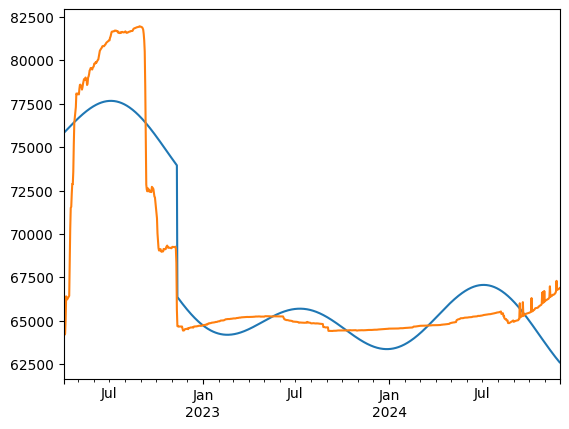

In [17]:
best_ff.predict(ff).plot()
aa["area"].plot()

In [18]:
aa.loc["2022-02-03":]

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-11-26,66785.290876,0
2024-11-27,66811.948125,0
2024-11-28,66822.654797,0
2024-11-29,66837.300818,0


In [19]:
xx = (
    pd.DataFrame(index=aa.index).assign(
        ru_holiday=lambda x: [d in ru_holidays for d in x.index],
        ua_holiday=lambda x: [d in ua_holidays for d in x.index],
    )
).astype("int")

xx = add_trend(xx, "ct")
xx

,ru_holiday,ua_holiday,const,trend
2022-04-03,0,0,1.0,1.0
2022-04-04,0,0,1.0,2.0
2022-04-05,0,0,1.0,3.0
2022-04-06,0,0,1.0,4.0
2022-04-07,0,0,1.0,5.0
...,...,...,...,...
2024-11-26,0,0,1.0,969.0
2024-11-27,0,0,1.0,970.0
2024-11-28,0,0,1.0,971.0
2024-11-29,0,0,1.0,972.0


In [20]:
best_model = None
for p in range(6):
    for q in range(6):
        mod = ARIMA(aa["area"], order=(p, 1, q)).fit()
        if best_model is None or best_model.aic > mod.aic:
            best_model = mod
best_model.summary()

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   area   No. Observations:                  973
Model:                 ARIMA(5, 1, 4)   Log Likelihood               -6557.341
Date:                Sat, 30 Nov 2024   AIC                          13134.683
Time:                        12:21:39   BIC                          13183.476
Sample:                    04-03-2022   HQIC                         13153.253
                         - 11-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7485      0.097      7.707      0.000       0.558       0.939
ar.L2         -0.3823      0.100     -3.835      0.000      -0.578      -0.187
ar.L3          0.4205      0.088      4.771      0.000       0.248       0.593
ar.L4          0.4683      0.093      5.056      0.000       0.287       0.650
ar.L5         -0.2860      0.025    -11.498      0.000      -0.335      -0.237
ma.L1         -0.3340      0.100     -3.348      0.001      -0.530      -0.138
ma.L2          0.3252      0.064      5.061      0.000       0.199       0.451
ma.L3         -0.4212      0.066     -6.341      0.000      -0.551      -0.291
ma.L4         -0.4389      0.075     -5.821      0.000      -0.587      -0.291
sigma2      3.585e+04    371.756     96.423      0.000    3.51e+04    3.66e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.34   Jarque-Bera (JB):             90511.78
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -3.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
fh = 120  # int(365.25 * 5)
fcst = best_model.get_forecast(fh, alpha=0.05).summary_frame()
fcst.index = pd.date_range(
    start=aa.index.max() + pd.DateOffset(days=1), periods=fcst.shape[0], freq="D"
)
fcst

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


area,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-12-01,66943.448351,189.329779,66572.368803,67314.527898
2024-12-02,67005.643173,327.973670,66362.826592,67648.459754
2024-12-03,66989.116423,455.256583,66096.829916,67881.402930
2024-12-04,66979.340084,557.322743,65887.007579,68071.672588
2024-12-05,67025.290651,656.000216,65739.553855,68311.027447
...,...,...,...,...
2025-03-26,67704.985786,6554.601103,54858.203691,80551.767881
2025-03-27,67707.141473,6596.452485,54778.332178,80635.950769
2025-03-28,67708.663193,6638.152557,54698.123257,80719.203129
2025-03-29,67710.269839,6679.696946,54618.304397,80802.235281


In [22]:
svo_end_alpha = 99.95
svo_end_km_ration = 0.01
hh = fcst[["mean", "mean_se"]].diff() / fcst[["mean", "mean_se"]].abs()
end_svo = hh[
    (hh["mean_se"] <= 1 - svo_end_alpha / 100) & (hh["mean"] <= svo_end_km_ration / 100)
].index.min()
fcst = fcst[:end_svo]
# fh = fcst.shape[0]
fh = 90

In [23]:
country_area = {
    "Черногория": 14026,
    "Словения": 20253,
    "Северная Македония": 25333,
    "Албания": 28748,
    "Бельгия": 32528,
    "Молдавия": 33843,
    "Швейцария": 41290,
    "Нидерланды": 41526,
    "Дания": 42895,
    "Эстония": 45226,
    "Босния и Герцеговина": 51129,
    "Хорватия": 56542,
    "Латвия": 64589,
    "Литва": 65200,
    "Ирландия": 70273,
    "Чехия": 78866,
    "Австрия": 83858,
}

In [36]:
offset = 40
max_idx = aa.iloc[-365 - offset : -offset]["area"].idxmax()
max_val = round(aa.iloc[-365 - offset : -offset]["area"].max() / 1000, 1)

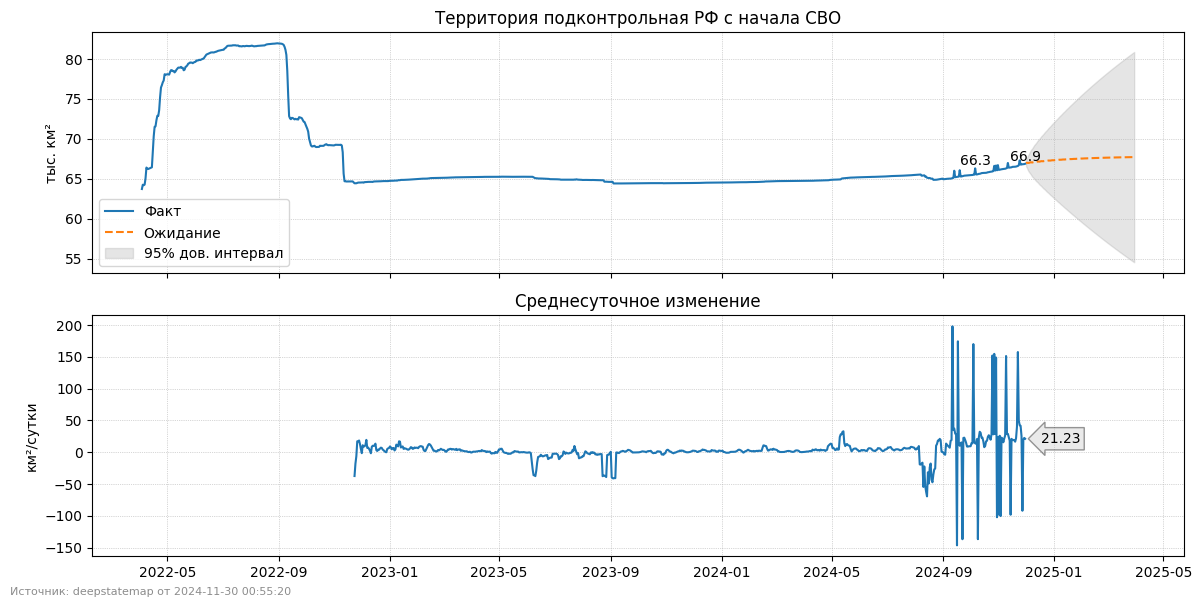

In [37]:
# sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax = axs[0]
sns.lineplot(aa["area"] / 1000, ax=ax, label="Факт")
sns.lineplot(fcst["mean"] / 1000, ls="--", ax=ax, label="Ожидание")
fill_95p = ax.fill_between(
    fcst.index,
    fcst["mean_ci_lower"] / 1000,
    fcst["mean_ci_upper"] / 1000,
    alpha=0.2,
    color="grey",
)
fill_95p.set_label("95% дов. интервал")
ax.legend()
ax.set(
    xlabel=None,
    ylabel="тыс. км\u00b2",
    title="Территория подконтрольная РФ с начала СВО",
)

ax.text(max_idx, max_val, f"{max_val:.1f}", ha="center", va="bottom")

ax.text(
    aa["area"].index.max(),
    aa["area"].iloc[-1] / 1000,
    f'{aa['area'].iloc[-1]/1000:.1f}',
    ha="center",
    va="bottom",
)

ax = axs[1]
ax.set(
    xlabel=None,
    ylabel="км\u00b2/сутки",
    title="Среднесуточное изменение",
)
day_din_area = aa.diff()["2022-11-23":].rolling(5, center=True, min_periods=3).mean()
sns.lineplot(
    day_din_area["area"],
    ax=ax,
    legend=None,
)
bbox = dict(boxstyle="larrow", fc="0.8", alpha=0.4)
dy = day_din_area.iloc[-1].values[0]
dx = day_din_area.index.max()
ax.annotate(
    f"{dy:.2f}",
    (dx + datetime.timedelta(days=16 + int(fh / 60)), dy),
    # xytext=(-2, 1),
    bbox=bbox,
    va="center",
    ha="left",
)
for ax in axs:
    ax.grid(ls=":", lw=0.5)
fig.tight_layout()
fig.text(
    0,
    0,
    f"Источник: deepstatemap от {last_date}",
    fontdict={"size": 8},
    alpha=0.45,
)
Path("img/").mkdir(exist_ok=True)
fig.savefig(Path("img/area.png"), format="png", dpi=300)